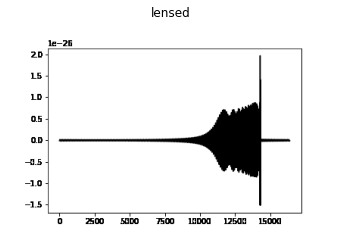

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets
import matplotlib.pyplot as plt

data_path = 'data/train'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Normalize((0.5), (0.5)),
#     torchvision.transforms.Resize((128,128),interpolation=Image.NEAREST)
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    num_workers=16,
    shuffle=True
)

test_path = "data/test"

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=5,
    num_workers=16,
    shuffle=True
)

validate_path = "data/validate"

validate_dataset = torchvision.datasets.ImageFolder(
    root=validate_path,
    transform=transform
)
validate_loader = torch.utils.data.DataLoader(
    validate_dataset,
    batch_size=5,
    num_workers=16,
    shuffle=True
)


labels_map={1: "unlensed", 0: "lensed"}

img, label = train_dataset[0]
plt.axis("off")
plt.title(labels_map[label])
plt.imshow(img.squeeze(), cmap="gray")
# for batch_idx, (data, target) in enumerate(train_loader):
    

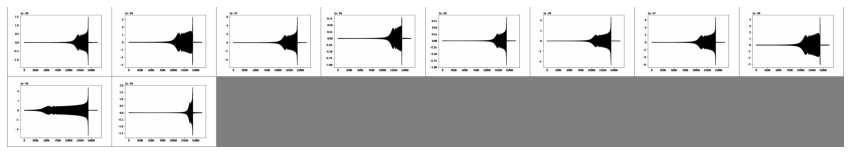

unlensed lensed unlensed lensed unlensed


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,5))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%s' %labels_map[labels[j].item()] for j in range(5)))

In [3]:
labels

tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 1])

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*69*105, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*69*105)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
device = torch.device("cuda:0")

In [6]:
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=115920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

In [8]:
train_accuracy = [0]
validate_accuracy = [0]
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    val_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs.squeeze().float(), labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    with torch.no_grad():
        for data in train_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
    #         print(outputs.float)
            predicted = torch.round(outputs.squeeze().float())
    #         print(predicted)
    #         print(labels)
            c = (predicted == labels).squeeze()
    #         print(c)

            for i in range(len(c)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    train_accuracy.append(sum(class_correct)/sum(class_total))
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    with torch.no_grad():
        for data in validate_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
    #         print(outputs.float)
            predicted = torch.round(outputs.squeeze().float())
    #         print(predicted)
    #         print(labels)
            c = (predicted == labels).squeeze()
    #         print(c)

            for i in range(len(c)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    validate_accuracy.append(sum(class_correct)/sum(class_total))
            

print('Finished Training')

[1,   100] loss: 0.0179291019
[1,   200] loss: 0.0123171342
[1,   300] loss: 0.0121670367
[1,   400] loss: 0.0120873449
[1,   500] loss: 0.0119825049
[1,   600] loss: 0.0118379466
[1,   700] loss: 0.0117011189
[1,   800] loss: 0.0115905383
[2,   100] loss: 0.0114545156
[2,   200] loss: 0.0113659070
[2,   300] loss: 0.0112022106
[2,   400] loss: 0.0110552208
[2,   500] loss: 0.0109016592
[2,   600] loss: 0.0107631865
[2,   700] loss: 0.0105171407
[2,   800] loss: 0.0103666128
[3,   100] loss: 0.0101382971
[3,   200] loss: 0.0101167259
[3,   300] loss: 0.0099142659
[3,   400] loss: 0.0096786419
[3,   500] loss: 0.0095585955
[3,   600] loss: 0.0093526634
[3,   700] loss: 0.0091394899
[3,   800] loss: 0.0089198290
[4,   100] loss: 0.0086649163
[4,   200] loss: 0.0083762448
[4,   300] loss: 0.0080703657
[4,   400] loss: 0.0079745187
[4,   500] loss: 0.0075864585
[4,   600] loss: 0.0074109958
[4,   700] loss: 0.0071878598
[4,   800] loss: 0.0069224305
[5,   100] loss: 0.0064761491
[5,   200]

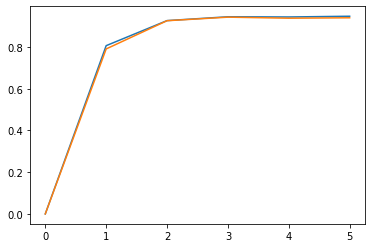

In [9]:
plt.plot(train_accuracy)
plt.plot(validate_accuracy)

In [40]:
train_accuracy

[0.9995, 0.99975, 0.99975, 1.0, 1.0]

In [27]:
net.to(torch.device("cpu"))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=115920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [25]:
for data in test_loader:
    images, labels = data
    print(len(images))

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
2


In [32]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
#         print(outputs.float)
        predicted = torch.round(outputs.squeeze().float())
#         print(predicted)
#         print(labels)
        c = (predicted == labels).squeeze()
#         print(c)

        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        labels_map[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  : 100 %


In [34]:
class_total

[501.0, 501.0]

In [105]:
int(labels[3])

IndexError: index 3 is out of bounds for dimension 0 with size 1

In [63]:
?torchvision.transforms.Normalize

In [29]:
len(train_dataset)

8004